In [1]:
# Import libraries
import os
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import cv2
import random

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive


In [2]:
# Create dataframe to store and manage image data

good_fol = 'good' # folder containing good image samples
bad_fol = 'bad' # folder containing bad image samples

# Initialize dataframe columns
img_set = []
product_code = []
img_name = []

# Walk through sub-folders 
for fol in [good_fol, bad_fol]:
    for root, _, files in os.walk(fol):
        num = os.path.basename(root)
        for file in files:
            if file.endswith(('.jpg', '.mp4')):
                img_set.append(fol)
                product_code.append(num)
                img_name.append(file)

# Define dataframe
img_df = pd.DataFrame({
    'Set': img_set,
    'Product': product_code,
    'Name': img_name
})

# Add column for bad image category labels
bad_cat = pd.read_csv('bad_pictures_categorization.csv',sep=';',names=['Name','Label'])
img_df = pd.merge(img_df,bad_cat,on='Name',how='left')

img_df


,Set,Product,Name,Label
0,good,0501010207,3097773_0501010207.1.mp4,NaN
1,good,0501010207,3097776_0501010207.1.jpg,NaN
2,good,0501010207,3097776_0501010207.2.jpg,NaN
3,good,0501010207,3097776_0501010207.3.jpg,NaN
4,good,0501010207,3097779_0501010207.1.mp4,NaN
...,...,...,...,...
4968,bad,8002260506,6657671_8002260506.1.mp4,G
4969,bad,8002431101,1651185_8002431101.1.mp4,NC
4970,bad,8002431101,1671161_8002431101.3.jpg,NC
4971,bad,8002431101,1756169_8002431101.3.jpg,NC


In [3]:
# Count the number of images and videos
count_jpg = 0
count_mp4 = 0

for _, row in img_df.iterrows():
    file_name = row["Name"]
    if file_name.endswith(".jpg"):
        count_jpg+=1
    else:
        count_mp4+=1
    
print("Number of images: ", count_jpg)
print("Number of videos: ", count_mp4)

Number of images:  3802
Number of videos:  1171


In [4]:
# Explore the image data distribution

product_set = img_df.groupby(['Product', 'Set']).size().unstack(fill_value=0) # group by product and set
product_label_df = img_df[img_df['Set'] == 'bad'].groupby(['Product', 'Label']).size().unstack(fill_value=0) # group by product and bad category label

img_product_df = pd.merge(product_set, product_label_df, on='Product', how='left') # merge both
img_product_df = img_product_df.fillna(0).reset_index()

# Totalize columns
total_row = img_product_df.iloc[:, 1:].sum()
total_row['Product'] = 'Total'

# Add row with totals
img_product_df = pd.concat([img_product_df, total_row.to_frame().T], ignore_index=True)

img_product_df

,Product,bad,good,BL,BOX,G,NC,NP,SCR,TMP
0,0501010207,1,55,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0501020101,0,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0504020118,5,59,0.0,0.0,0.0,2.0,0.0,3.0,0.0
3,05060103250,14,43,3.0,0.0,4.0,1.0,3.0,3.0,0.0
4,1001040106,9,45,0.0,0.0,4.0,1.0,0.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...
79,8001051202,4,69,0.0,0.0,3.0,1.0,0.0,0.0,0.0
80,8002260506,12,45,0.0,0.0,1.0,0.0,0.0,11.0,0.0
81,8002431101,3,50,0.0,0.0,0.0,3.0,0.0,0.0,0.0
82,8003020202,1,53,0.0,0.0,0.0,0.0,0.0,0.0,1.0


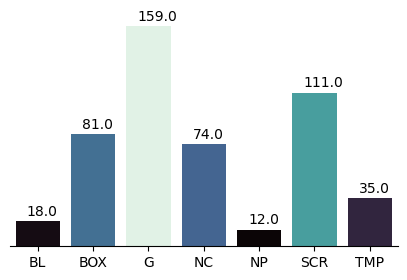

In [5]:
# Histogram of bad category labels

cat_labels = img_product_df.columns[3:].to_list()
cat_totals = img_product_df.iloc[-1, -7:].to_list()

norm = plt.Normalize(min(cat_totals), max(cat_totals))
cmap = sns.color_palette("mako", as_cmap=True)
colors = [cmap(norm(value)) for value in cat_totals]  

fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(y=cat_totals, x=cat_labels, hue=cat_labels, palette=colors, dodge=False, legend=False)

ax.tick_params(axis='y', bottom=False)
plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

for i, v in enumerate(cat_totals):
    plt.text(i-.2, v + 2, str(v), color='black', va='bottom')

plt.show()

In [6]:
# Correct the number of bad and good images per product
img_product_df["good_"] = img_product_df["good"] + img_product_df["G"]
img_product_df["bad_"] = img_product_df["bad"] - img_product_df["G"]
img_product_df

,Product,bad,good,BL,BOX,G,NC,NP,SCR,TMP,good_,bad_
0,0501010207,1,55,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55.0,1.0
1,0501020101,0,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0.0
2,0504020118,5,59,0.0,0.0,0.0,2.0,0.0,3.0,0.0,59.0,5.0
3,05060103250,14,43,3.0,0.0,4.0,1.0,3.0,3.0,0.0,47.0,10.0
4,1001040106,9,45,0.0,0.0,4.0,1.0,0.0,3.0,1.0,49.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
79,8001051202,4,69,0.0,0.0,3.0,1.0,0.0,0.0,0.0,72.0,1.0
80,8002260506,12,45,0.0,0.0,1.0,0.0,0.0,11.0,0.0,46.0,11.0
81,8002431101,3,50,0.0,0.0,0.0,3.0,0.0,0.0,0.0,50.0,3.0
82,8003020202,1,53,0.0,0.0,0.0,0.0,0.0,0.0,1.0,53.0,1.0


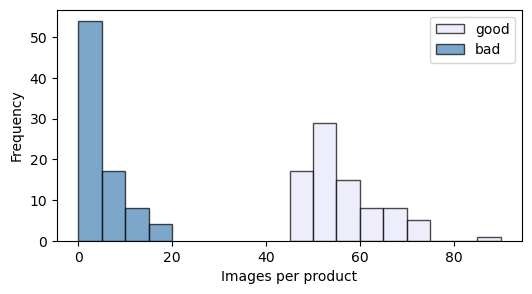

In [7]:
# Histogram of the number of good and bad images per product
img_product_df_ = img_product_df[img_product_df["Product"] != "Total"] # Filter the total row

good_bins = range(int(min(img_product_df_["good_"])), int(max(img_product_df_["good_"])) + 5, 5)
bad_bins = range(int(min(img_product_df_["bad_"])), int(max(img_product_df_["bad_"])) + 5, 5)

plt.figure(figsize=(6, 3))

plt.hist(img_product_df_["good_"], bins=good_bins, color="lavender", alpha=0.7, edgecolor="black", label="good")

plt.hist(img_product_df_["bad_"], bins=bad_bins, color="steelblue", alpha=0.7, edgecolor="black", label="bad")

plt.xlabel("Images per product")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [8]:
# Give the correct set class to bad images labeled 'G'
img_df['Set_c'] = img_df['Set']
img_df.loc[img_df['Label'] == 'G', 'Set_c'] = 'good'

img_df.to_csv('img.csv', index=False) # save df

In [9]:
# Load img df
dtypes = {
    "Set": "str",
    "Product": "str",
    "Name": "str",
    "Label": "str",
    "Set_c": "str",
}

img_df = pd.read_csv("img.csv", dtype=dtypes)
img_df

,Set,Product,Name,Label,Set_c
0,good,0501010207,3097773_0501010207.1.mp4,NaN,good
1,good,0501010207,3097776_0501010207.1.jpg,NaN,good
2,good,0501010207,3097776_0501010207.2.jpg,NaN,good
3,good,0501010207,3097776_0501010207.3.jpg,NaN,good
4,good,0501010207,3097779_0501010207.1.mp4,NaN,good
...,...,...,...,...,...
4968,bad,8002260506,6657671_8002260506.1.mp4,G,good
4969,bad,8002431101,1651185_8002431101.1.mp4,NC,bad
4970,bad,8002431101,1671161_8002431101.3.jpg,NC,bad
4971,bad,8002431101,1756169_8002431101.3.jpg,NC,bad


In [10]:
# Count the number of images and videos for each class
jpg_good = 0
jpg_bad = 0
mp4_good = 0
mp4_bad = 0

for _, row in img_df.iterrows():
    file_name = row["Name"]
    cat = row["Set_c"]
    if file_name.endswith(".jpg"):
        if cat=='good':
            jpg_good+=1
        else:
            jpg_bad+=1
    else:
        if cat=='good':
            mp4_good+=1
        else:
            mp4_bad+=1

print("good images: ", jpg_good)
print("bad images: ", jpg_bad)
print("good videos: ", mp4_good)
print("bad videos: ", mp4_bad)

good images:  3533
bad images:  269
good videos:  1109
bad videos:  62


In [ ]:
# Save the less blurry frame of videos as images and store them in 'v2i' folder

v2i_df = pd.DataFrame(columns=["Set", "Product", "Name", "Label", "Set_c"]) # df to store the image info

max_frames = 1000 # ~17 sec 

for _, row in img_df.iterrows():
    file_name = row["Name"]
    if file_name.endswith(".mp4"):
        # Open video
        video_path = os.path.join(row["Set"], row["Product"], file_name)
        cap = cv2.VideoCapture(video_path)

        max_blur = -1  
        best_frame = None  
        frame_count = 0

        # Check for best frame
        while frame_count < max_frames:
            ret, frame = cap.read()
            if not ret:
                break 

            blur_score = cv2.Laplacian(frame, cv2.CV_64F).var() # apply laplacian filter
            if blur_score > max_blur:
                max_blur = blur_score
                best_frame = frame
            
            frame_count += 1

        cap.release()

        # Save best frame
        if best_frame is not None:
            image_name = file_name.replace(".mp4", ".jpg")
            save_path = os.path.join("v2i", row["Set"], row["Product"])
            os.makedirs(save_path, exist_ok=True)
            full_path = os.path.join(save_path, image_name)
            cv2.imwrite(full_path, best_frame)

            new_row = pd.DataFrame([{
                "Set": row["Set"],
                "Product": row["Product"],
                "Name": image_name,
                "Label": row["Label"],
                "Set_c": row["Set_c"]
            }])
            v2i_df = pd.concat([v2i_df, new_row], ignore_index=True) # add row to df

v2i_df.to_csv('v2i.csv', index=False)

In [ ]:
v2i_df = pd.read_csv("v2i.csv", dtype=dtypes)
v2i_df.head(20)

In [ ]:
# Generate augmentations for bad images and store them in 'aug' folder

orig_img = pd.concat([img_df,v2i_df], ignore_index=True) # combine all original image info in one df
aug_df = pd.DataFrame(columns=['Set', 'Product', 'Name', "Label", "Set_c"]) # df to store augmentations info

for index, row in orig_img.iterrows():
    if row['Set_c'] == 'bad' and row['Name'].endswith('.jpg'): # ensure file is a bad image (not video)
        # Read image
        image_path = os.path.join(row['Set'], row['Product'], row['Name'])
        image = cv2.imread(image_path)

        augmentations = [] # augmentation list

        # Augmentation 1: flip across the vertical axis
        augmentations.append(cv2.flip(image, 1)) 

        # Augmentations 2-7: random crop random and resize
        for _ in range(6):
            height, width, _ = image.shape
            crop_x = random.randint(0, width // 3)
            crop_y = random.randint(0, height // 3)
            crop_width = random.randint(width // 2, width) 
            crop_height = random.randint(height // 2, height)
            cropped = image[crop_y:crop_y + crop_height, crop_x:crop_x + crop_width]
            resized = cv2.resize(cropped, (width, height)) 
            augmentations.append(resized)
        
        # Augmentations 8-9: random blur
        for _ in range(2):
            kernel_size = random.choice([7, 9, 11, 13])
            sigma = random.uniform(3.0, 5.0)
            blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
            augmentations.append(blurred)

        # Augmentations 10-13: random rotation
        for _ in range(4):
            angle_range=(-15, 15)
            height, width = image.shape[:2]
            angle = random.uniform(*angle_range)
            center = (width // 2, height // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated = cv2.warpAffine(image, rotation_matrix, (width, height), borderMode=cv2.BORDER_REFLECT)
            augmentations.append(rotated)
        
        # Apply and save augmentations
        for i, aug_image in enumerate(augmentations, start=1):
            aug_name = f"{os.path.splitext(row['Name'])[0]}.aug{i}.jpg"
            save_path = os.path.join('aug', row['Set'], row['Product'], aug_name)
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            cv2.imwrite(save_path, aug_image)
            
            new_aug = pd.DataFrame({
                'Set': [row['Set']],
                'Product': [row['Product']],
                'Name': [aug_name],
                'Label': [row['Label']],
                'Set_c': [row['Set_c']]
            })

            aug_df = pd.concat([aug_df, new_aug], ignore_index=True) # add augmentations info to df

aug_df.to_csv('aug.csv', index=False)

In [ ]:
aug_df = pd.read_csv("aug.csv", dtype=dtypes)
aug_df

In [ ]:
# Helper functions for Google Drive uploads

# Open browser for Google account authentification
def authenticate_pydrive():
    gauth = GoogleAuth()
    gauth.LocalWebserverAuth()
    return GoogleDrive(gauth)

# Upload function
def upload_images_to_drive(drive, df, good_fol_id, bad_fol_id, root_fol=""):
    """
    Upload images to Google Drive folders based on 'Set_c',
    with local paths constructed from 'Set'
    
    Args:
        drive: pydrive instance
        df: df with images info
        good_fol_id: folder id for 'good' images in Google Drive
        bad_fol_id: folder id for 'bad' images in Google Drive
    """
    for _, row in df.iterrows():
        set = row['Set']
        set_c = row['Set_c']
        name = row['Name']
        product = row['Product']

        if name.endswith('.jpg'): # verify file it's an image
            local_path = os.path.join(root_fol, set, product, name) # local path
            fol_id = good_fol_id if set_c == 'good' else bad_fol_id # destination path (Google Drive)

            # Upload the file to Google Drive
            fdata = {'title': name, 'parents': [{'id': fol_id}]}
            gfile = drive.CreateFile(fdata)
            gfile.SetContentFile(local_path)
            gfile.Upload()

            print(f"Uploaded: {local_path} -> {set_c}")


In [ ]:
# Upload images to Google Drive

# Authentication
drive = authenticate_pydrive()

# Google Drive folder IDs (to be replaced by the user)
good_fol_id = "id-good-folder"
bad_fol_id = "id-bad-folder"

# Upload each group of images 
upload_images_to_drive(drive, img_df, good_fol_id, bad_fol_id)
upload_images_to_drive(drive, v2i_df, good_fol_id, bad_fol_id, root_fol="v2i")
upload_images_to_drive(drive, aug_df, good_fol_id, bad_fol_id, root_fol="aug")
